In [149]:
import pickle
import os
import numpy as np
import pandas as pd
from PIL import ImageFont

from utils import Fold, Gestures
import matplotlib.pyplot as plt
import visualkeras
from tensorflow import keras
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [150]:

def load_pickle(basepath, name):
    save_path = os.path.join(basepath, name)

    with open(save_path, 'rb') as file:
        dictionary = pickle.load(file)
        return dictionary

def display_results(data: dict):
    for model_type in data:
        print("%s results using %d iterations:" % (model_type, data.get(model_type).get('iterations')))
        sorted_folds = list(data.get(model_type).get('folds').keys())
        sorted_folds.sort(key=lambda x: x.value)
        for fold in sorted_folds:
            print("\t%d-fold results:" % fold.value)
            fold_results = data.get(model_type).get('folds').get(fold)

            acc_per_fold = np.array(list(map(lambda x: x['acc_per_fold'], fold_results)))
            loss_per_fold = np.array(list(map(lambda x: x['loss_per_fold'], fold_results)))
            print("\t\tIndividual accuracies:")
            for acc in acc_per_fold:
                print("\t\t%.3f" % acc.mean(), end='')
            acc_per_fold = acc_per_fold.flatten()
            loss_per_fold = loss_per_fold.flatten()
            print("\n\t\tOverall acc: %.2f Std: %.2f" % (acc_per_fold.mean(), acc_per_fold.std()))
            print("\t\tOverall loss: %.2f" % loss_per_fold.mean())


def draw_conf_matrix(confusions, base_path: str, name: str):
    reshaped = confusions.reshape(confusions.shape[0] * confusions.shape[1], 10, 10)

    overall_confusion = np.zeros((reshaped.shape[1], reshaped.shape[2]))
    for conf in reshaped:
        overall_confusion = np.add(overall_confusion, conf)

    # Normalize predictions
    normalized_confusion = overall_confusion / overall_confusion.sum(axis=1, keepdims=1)
    normalized_confusion = normalized_confusion.round(decimals=2)

    save_path = os.path.join(base_path, f"{name.replace(' ', '_')}.svg")
    if not os.path.exists(base_path):
        os.mkdir(base_path)

    ConfusionMatrixDisplay(normalized_confusion, display_labels=Gestures).plot(cmap='Blues', xticks_rotation='vertical')
    plt.title(name)
    plt.savefig(save_path, bbox_inches="tight")

    plt.show()

In [151]:
# Analyze accuracies
conv_lstm = load_pickle('../results', 'conv_lstm.pickle')
display_results(conv_lstm)

ConvLSTM 128 results using 3 iterations:
	10-fold results:
		Individual accuracies:
		71.201		70.912		70.954
		Overall acc: 71.02 Std: 5.50
		Overall loss: 1.48


In [154]:
# Analyze accuracies
# lstm = load_pickle('../results', 'lstm.pickle')
# display_results(lstm)

UnpicklingError: invalid load key, 'v'.

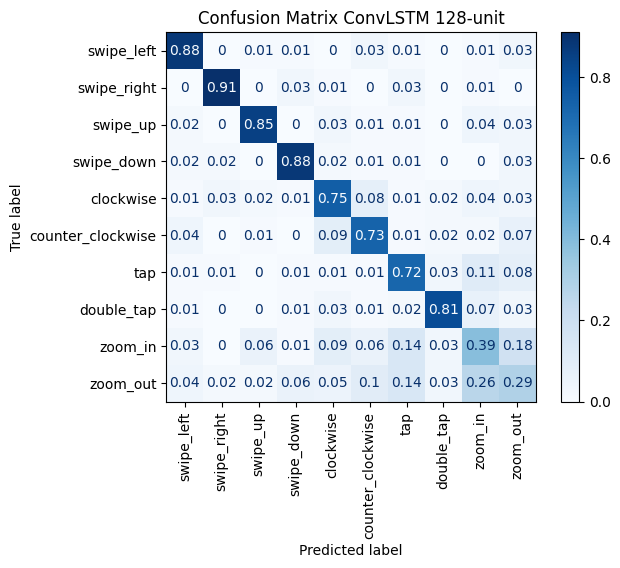

In [156]:
conv_lstm = load_pickle('../results', 'conv_lstm.pickle')
fold_ten = conv_lstm.get('ConvLSTM 128').get('folds').get(Fold.TEN)

confusions = np.array(list(map(lambda x: x['confusion_per_fold'], fold_ten)))
draw_conf_matrix(confusions, '../results/figs/', "Confusion Matrix ConvLSTM 128-unit")

In [ ]:
history = list(map(lambda x: x['history_per_fold'], fold_ten))
single_loss = history[0][0].history['loss']
single_acc = history[0][0].history['acc']

plt.plot(single_loss)
plt.plot(single_acc)

In [ ]:
loss = []
acc = []

for h_array in history:
    for h in h_array:
        loss.append(h.history['loss'])
        acc.append(h.history['acc'])

loss = np.array(loss)
acc = np.array(acc)

dim = loss.shape[1]
avg_loss = np.zeros(dim)
avg_acc = np.zeros(dim)
for l in loss:
    avg_loss += l

for a in acc:
    avg_acc += a

plt.plot(avg_loss / dim, 'r.', label='Average loss')
plt.plot(avg_acc / dim, 'g.', label='Average accuracy')
plt.legend()
plt.show()

In [ ]:
# Analyze file sizes
base = '../models'
for model in os.listdir(base):
    print(model)
    path = os.path.join(base, model)
    tflite_size = os.path.getsize(os.path.join(path, f"{model}.tflite"))
    tflite_quantized_size = os.path.getsize(os.path.join(path, f"{model}_quantized.tflite"))
    print("\tNormal size: %d bytes (%.1f Kb)\n\tQuantized size: %d bytes (%.1f Kb)" % (tflite_size, round(float(tflite_size / 1000), 1), tflite_quantized_size, round(float(tflite_quantized_size / 1000), 1)))

In [ ]:
df = pd.DataFrame({
    'Model Name': ['ConvLSTM 16', 'ConvLSTM 32', 'ConvLSTM 64', 'ConvLSTM 128', 'LSTM 16', 'LSTM 32', 'LSTM 64', 'LSTM 128', 'LSTM 64 + D. 64', 'LSTM 64 + D. 128', 'LSTM Bd. 64', 'LSTM Bd. 64 + D. 128'],
    'Accuracy 5-fold': [0.6578, 0.6936, 0.7042, 0.7016, 0.6372, 0.6447, 0.6560, 0.6668, 0.6798, 0.6934, 0.6609, 0.6692],
    'Accuracy 10-fold': [0.6731, 0.6966, 0.6998, 0.7072, 0.6571, 0.6632, 0.6731, 0.6812, 0.6923, 0.686, 0.6674, 0.6929],
    'Original Size': [3910, 4207, 5047, 7709, 723, 1497, 3292, 7864, 17148, 33560, 6574, 67051],
    'Quantized Size': [1126, 1202, 1417, 2091, 220, 415, 868, 2019, 4338, 8443, 1721, 16848],
    'Inference Arduino': [3696, 4994, 6585, 11419, 971, 2532, 7776, 26773, 8052, None, None, None],
    'Inference ESP32': [8268, 8445, 9190, 12699, 332, 808, 2371, 16708, 3066, 3982, None, None]
})

df['Original Size'] = df['Original Size'] / 10
df['Quantized Size'] = df['Quantized Size'] / 10

df['Inference Arduino'] = df['Inference Arduino'] / 10
df['Inference ESP32'] = df['Inference ESP32'] / 10

df

In [ ]:
df_conv_lstm = df[:4]
df_lstm = df[4:]

In [ ]:
df.plot(kind='bar', xlabel='Model', ylabel='Accuracy', y=['Accuracy 5-fold', 'Accuracy 10-fold'], ylim=(0.60, 0.75), rot=90)
plt.xticks(df.index, df['Model Name'], rotation=45, ha='right')
plt.savefig('../results/figs/fold_res_all.svg', bbox_inches='tight')
plt.show()

In [ ]:
df.plot(kind='bar', x='Model Name', xlabel='Model', ylabel='Size (Kb)', y=['Original Size', 'Quantized Size'], rot=90, ylim=(10, 1000))
plt.show()

In [ ]:
df.plot(kind='line', x='Model Name', xlabel='Model', ylabel='Inference time (ms)', y=['Inference Arduino', 'Inference ESP32'])
plt.xticks(df.index, df['Model Name'], rotation=45, ha='right')
plt.savefig('../results/figs/inference_times_all.svg', bbox_inches='tight')
plt.show()

In [ ]:
conv_lstm_model = keras.models.load_model('../models/conv_lstm_128/tf/')

font = ImageFont.truetype("../RobotoSlab-VariableFont_wght.ttf", 32)
visualkeras.layered_view(conv_lstm_model, min_xy=160, font=font, scale_z=1, spacing=50, legend=True, to_file='../results/figs/visual_conv_lstm_128.png').show()